# Introduction

The Expectation-Maximization (EM) algorithm is a way to find maximum-likelihood estimates for model parameters when your data is incomplete, has missing data points, or has unobserved (hidden) latent variables. It is an iterative way to approximate the maximum likelihood function.

## MLE vs. EM
Although Maximum Likelihood Estimation (MLE) and EM can both find “best-fit” parameters, how they find the models are very different. MLE accumulates all of the data first and then uses that data to construct the most likely model. EM takes a guess at the parameters first — accounting for the missing data — then tweaks the model to fit the guesses and the observed data. 

## generate Gaussian mixture data
First we generated data according to the given Guassian mixture modeling with$$\mu_{1}=[10,3]^{\mathrm{T}}, \quad \mu_{2}=[1,1]^{\mathrm{T}}, \quad \mu_{3}=[5,4]^{\mathrm{T}}$$ and
$$\Sigma_{1}=\left[\begin{array}{ll}{1} & {0} \\ {0} & {1}\end{array}\right], \quad \Sigma_{2}=\left[\begin{array}{cc}{1.5} & {0} \\ {0} & {1.5}\end{array}\right], \quad \Sigma_{3}=\left[\begin{array}{ll}{2} & {0} \\ {0} & {2}\end{array}\right]$$
we can generate the data as below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal

def generate_data(n_data, means, covariances):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [10, 3],
    [1, 1],
    [5, 4]
])

init_covariances = np.array([
    [[1, 0.], [0, 1]],
    [[1.5, 0], [0, 1.5]],
    [[2, 0], [0, 2]]
])

# generate data
np.random.seed(4)
X = generate_data(300, init_means, init_covariances)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()

## The basic steps for the EM algorithm are:\

1.An initial guess is made for the model’s parameters and a probability distribution is created. This is sometimes called the “E-Step” for the “Expected” distribution.\
2.Newly observed data is fed into the model.\
3.The probability distribution from the E-step is tweaked to include the new data. This is sometimes called the “M-step.”\
4.Steps 2 through 4 are repeated until stability (i.e. a distribution that doesn’t change from the E-step to the M-step) is reached.\


The E-Step:\
We start with 3 random Gaussian mixture models (given by the question), then calculate the posterior. After M-step, we get a new likelihood, thus we have a new posterier.

After calculating the posterior, next step is to estimate the parameters of each Gaussian model defined by the equations below and then evaluate the log-likelihood.  \
In M-Step:\
each time we will update the mean and sigma in each interation until finished all the interation\
We repeat these steps until convergence.\
Mean of the Gaussians:
$$
\mu_{k}^{n e w}=\frac{1}{N_{k}} \Sigma_{n=1}^{N} \gamma\left(z_{n k}\right) x_{n}
$$
Covariance of the Gaussians:
$$
\Sigma_{k}^{n e w}=\frac{1}{N_{k}} \Sigma_{n=1}^{N} \gamma\left(z_{n k}\right)\left(x_{n}-\mu_{k}^{n e w}\right)\left(x_{n}-\mu_{k}^{n e w}\right)^{T}
$$
$$
\pi_{k}^{n e w}=\frac{N_{k}}{N}
$$
Sum of responsibilities in each Gaussian k:
$$
N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)
$$
This is what we want to maximized:
$$
\ln p(X | \mu, \Sigma, \pi)=\Sigma_{n=1}^{N} \ln \left\{\Sigma_{k=1}^{K} \pi_{k} N\left(x_{n} | \mu_{k}, \Sigma_{k}\right)\right\}
$$

In [2]:
class EM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization
    """
    
    def __init__(self, n_components, n_iter, tol, seed):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.seed = seed

    def fit(self, X, means, cov):
        
        # data's dimensionality and responsibility vector
        self.n_row, self.n_col = X.shape     
        self.resp = np.zeros((self.n_row, self.n_components))
        
        # initialize parameters
        np.random.seed(self.seed)

        self.means = means
        self.weights = np.full(self.n_components, 1 / self.n_components)
        

        shape = self.n_components, self.n_col, self.n_col
        self.covs = cov
        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      
        
        for i in range(self.n_iter):
            self._do_estep(X)
            self._do_mstep(X)
            log_likelihood_new = self._compute_log_likelihood(X)
                
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)
            
        return self
      
    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k],allow_singular=True).pdf(X)
            self.resp[:, k] = prior * likelihood
        
        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return self
 
    def _do_mstep(self, X):
        """M-step, update parameters"""
        
        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / self.n_row
        
        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self
    
    
    def _compute_log_likelihood(self, X):
        """manually compute the log likelihood of the current parameter"""
        log_likelihood = 0
        for k in range(self.n_components):
            
            weight = self.weights[k]
            mean = self.means[k]
            cov = self.covs[k]
            if np.linalg.det(cov) != 0:
                cov_inverse = np.linalg.inv(cov)
            else :
                cov_inverse = [[1,0],[0,1]]
            term_other = np.log(2 * np.pi) + np.log(np.linalg.det(cov))
            
            for x in X:
                # compute (x-mu)^T * Sigma^{-1} * (x-mu)
                diff = x - mean
                term_exponent = np.dot(diff.T, np.dot(cov_inverse, diff))
            
                # compute loglikelihood contribution for this data point and this cluster             
                log_likelihood += -1 / 2 * (term_other + term_exponent) + np.log(weight)
            
        return log_likelihood
# Next, we will run our EM algorithm to discover the mixture components and visualize its output. When working with low-dimensional data, one useful way of testing our implementation is to visualize the gaussian components over the data at different points in the algorithm's execution:



In [3]:
from scipy.stats import multivariate_normal

def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    k = means.shape[0]
    x, y = np.mgrid[-5:14:.01, -3:8:.01]
    position = np.empty(x.shape + (2,))
    position[:, :, 0] = x
    position[:, :, 1] = y
    
    col = ['green', 'red', 'indigo']
    
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z = multivariate_normal(mean, cov).pdf(position)
        plt.contour(x, y, z)
        plt.xlim([-5, 14])
        plt.ylim([-3, 8])
    
    plt.tight_layout()

## b)
This is the contour of the initial Gaussian Mixture model with the given means and covariance as belows.
$$
\begin{aligned} \mu_{1}^{(0)}=[3,5]^{\mathrm{T}}, & \mu_{2}^{(0)}=[2,0.4]^{\mathrm{T}}, \quad \mu_{3}^{(0)}=[4,3]^{\mathrm{T}} \\ & \Sigma_{1}^{(0)}=\Sigma_{2}^{(0)}=\Sigma_{3}^{(0)}=\left[\begin{array}{cc}{1} & {0} \\ {0} & {1}\end{array}\right] \end{aligned}
$$

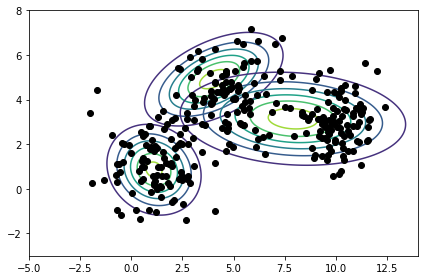

In [4]:
# use our implementation of the EM algorithm 
# and fit a mixture of Gaussians to the simulated data
means = [[3,5],[2,0.4],[4,3]]
cov = np.array([[[1., 0.], [0., 1]],[[1., 0.],[0., 1]], [[1, 0.],[0., 1]]])
em = EM(n_components = 3, n_iter = 1, tol = 1e-4, seed = 4)
em.fit(X, means,cov) 

plot_contours(X, em.means, em.covs, 'Initial clusters')

This is the contour of the Gaussian Mixture model after optimization with EM algorithm.

converged iteration: 100


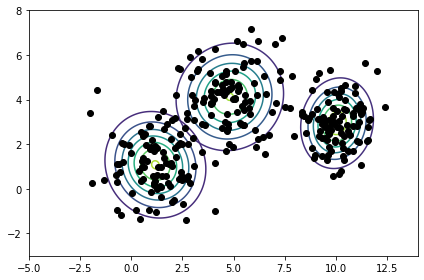

In [5]:
em = EM(n_components = 3, n_iter = 100, tol = 1e-4, seed = 4)
em.fit(X,means,cov)

print('converged iteration:', len(em.log_likelihood_trace))
plot_contours(X, em.means, em.covs, 'Final clusters')

## c)
Now we give another initial Gaussian Mixture model, see if the different initial model will result different result.
$$
\mu_{1}^{(0)}=[10,13]^{\mathrm{T}}, \quad \mu_{2}^{(0)}=[11,12]^{\mathrm{T}}, \quad \mu_{3}^{(0)}=[13,11]^{\mathrm{T}}
$$
$$
\Sigma_{1}^{(0)}=\Sigma_{2}^{(0)}=\Sigma_{3}^{(0)}=\left[\begin{array}{cc}{1} & {0} \\ {0} & {1}\end{array}\right]
$$

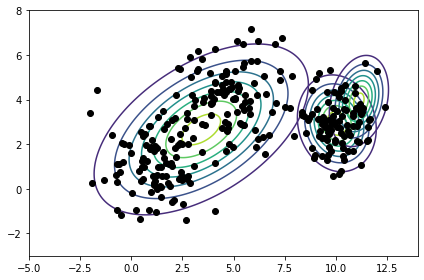

In [6]:
means = [[10,13],[11,12],[13,11]]
em = EM(n_components = 3, n_iter = 1, tol = 1e-4, seed = 4)
em.fit(X, means,cov) 

plot_contours(X, em.means, em.covs, 'Initial clusters')

It seems the result is different from the one above.\
The former one has proper initialization. 
Therefore it can be convergence with the real data distribution.\
But the latter one does not have a proper initialization, as there is too much overlap in the initial Gaussian distribution.

C:\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in log


converged iteration: 50


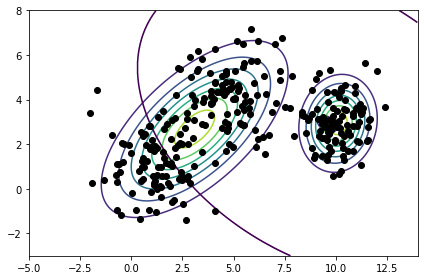

In [7]:
em = EM(n_components = 3, n_iter = 50, tol = 1e-4, seed = 4)
em.fit(X,means,cov)

print('converged iteration:', len(em.log_likelihood_trace))
plot_contours(X, em.means, em.covs, 'Final clusters')